In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from urllib.request import urlopen
import json
from scipy.interpolate import CubicSpline

In [31]:
def read_fmp():
    with open("../.fmp_api.key", "r") as f:
        api_key = f.read().strip()

    url = f"https://financialmodelingprep.com/stable/treasury-rates?from=2023-01-01&&apikey={api_key}"
    response = urlopen(url)
    return pd.DataFrame(json.loads(response.read().decode("utf-8")))


In [32]:
def save_json(data, filename):
    res = data.to_json(orient="records")
    with open(filename, "w") as f:
        json.dumps(f.write(res))


In [33]:
def load_json(filename):
    with open(filename, "rb") as f:
        data = json.loads(f.read())
    return pd.DataFrame(data)

In [ ]:
par_rates = load_json("../var/apr2025/par_rates.json")

,date,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30
0,2025-04-25,4.34,4.36,4.32,4.22,3.95,3.74,3.76,3.88,4.06,4.29,4.75,4.74
1,2025-04-24,4.34,4.37,4.32,4.22,3.97,3.77,3.80,3.91,4.11,4.32,4.79,4.77
2,2025-04-23,4.33,4.34,4.33,4.22,4.01,3.81,3.87,4.00,4.20,4.40,4.86,4.83
3,2025-04-22,4.33,4.35,4.33,4.21,3.98,3.76,3.82,3.98,4.19,4.41,4.90,4.88
4,2025-04-21,4.35,4.37,4.34,4.21,3.95,3.75,3.77,3.97,4.19,4.42,4.94,4.91


In [38]:
tenors = [(t, float(t.replace("month", "").replace("year","")) / \
           (12 if "month" in t else 1)) for t in par_rates.columns[1:]]

xt = np.concatenate((np.array([t[1] for t in tenors[:4]]), np.arange(1, 30.5, 0.5)))

tenors, xt

([('month1', 0.08333333333333333),
  ('month2', 0.16666666666666666),
  ('month3', 0.25),
  ('month6', 0.5),
  ('year1', 1.0),
  ('year2', 2.0),
  ('year3', 3.0),
  ('year5', 5.0),
  ('year7', 7.0),
  ('year10', 10.0),
  ('year20', 20.0),
  ('year30', 30.0)],
 array([ 0.08333333,  0.16666667,  0.25      ,  0.5       ,  1.        ,
         1.5       ,  2.        ,  2.5       ,  3.        ,  3.5       ,
         4.        ,  4.5       ,  5.        ,  5.5       ,  6.        ,
         6.5       ,  7.        ,  7.5       ,  8.        ,  8.5       ,
         9.        ,  9.5       , 10.        , 10.5       , 11.        ,
        11.5       , 12.        , 12.5       , 13.        , 13.5       ,
        14.        , 14.5       , 15.        , 15.5       , 16.        ,
        16.5       , 17.        , 17.5       , 18.        , 18.5       ,
        19.        , 19.5       , 20.        , 20.5       , 21.        ,
        21.5       , 22.        , 22.5       , 23.        , 23.5       ,
        24

In [39]:
def interpolate_curve(tenors, rates, xt):
    spline = CubicSpline(
        [t[1] for t in tenors], rates, bc_type="natural"
    )
    yt = spline(xt)
    return (pd.DataFrame(
            {
                "xt": xt,
                "par_rate": yt,
            }
        ).assign(key_rate = lambda df_: [1 if df_.xt.iloc[i] in [t[1] for t in tenors] else 0 for i in range(df_.shape[0])])
    )

interpolated_curve = interpolate_curve(tenors, par_rates.iloc[0, 1:], xt)

In [40]:
interpolated_curve

,xt,par_rate,key_rate
0,0.083333,4.340000,1
1,0.166667,4.360000,1
2,0.250000,4.320000,1
3,0.500000,4.220000,1
4,1.000000,3.950000,1
...,...,...,...
58,28.000000,4.761877,0
59,28.500000,4.756680,0
60,29.000000,4.751249,0
61,29.500000,4.745663,0


In [83]:
key_rates = \
(
    par_rates[par_rates.date.isin(["2025-04-25", "2025-03-31", "2024-12-31", "2023-12-29"])]
    .set_index("date")
    .apply(lambda x: interpolate_curve(tenors, x, xt).par_rate, axis=1)
    .T
    .assign(xt = xt.round(3),
            tenor = lambda df_: (df_.set_index("xt")
                                 .join(pd.DataFrame(tenors, columns = ["tenor", "years"])
                                       .assign(xt = lambda x: x.years.round(3))
                                       .set_index("xt"), how = "left")
                                 .reset_index()
                                 .tenor))
)

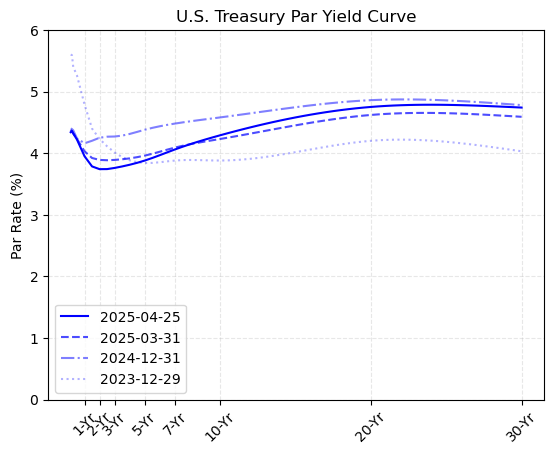

In [111]:
## plot the par curve for most recent data, prior month, beginning of year and last year
def plot_par_rates(data):
    dates = data.columns[:4]
    label_i = data.where(lambda df_: df_.tenor.notna() & df_.tenor.str.contains("year")).dropna().index
    x_labels = [f"{i}-Yr" for i in data.tenor.loc[label_i].str.replace("year","")]
    
    fig, ax = plt.subplots()
    ax.plot(data.xt, data.iloc[:, 0], label = dates[0], color='blue')
    ax.plot(data.xt, data.iloc[:, 1], label = dates[1], color='blue', alpha = 0.7, linestyle='--')
    ax.plot(data.xt, data.iloc[:, 2], label = dates[2], color='blue', alpha = 0.5, linestyle='-.')
    ax.plot(data.xt, data.iloc[:, 3], label = dates[3], color='blue', alpha = 0.3, linestyle=':')
    
    ax.set_title("U.S. Treasury Par Yield Curve")
    ax.set_ylabel("Par Rate (%)")
    ax.set_ylim(0, 6)
   
    ax.set_xticks(data.xt.loc[label_i])
    ax.set_xticklabels(x_labels, rotation=45)
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend()
    plt.show()

plot_par_rates(key_rates)

In [112]:
def bootstrapSpotRates(par_rates):
    """
    Compute the spot rate for a given maturity i using the par rates.
    """
    spot_rates = []
    subyear_counter = 0
    for i in range(par_rates.shape[0]):
        if par_rates.iloc[i, 0] < 1:
            spot_rates.append(par_rates.iloc[i, 1])
            subyear_counter += 1
        else:
            fv = 100
            c = par_rates.iloc[i, 1] / 2.
            xt = np.arange(0.5, par_rates.iloc[i, 0] + 0.5, 0.5)
            rt = spot_rates[subyear_counter - 1:]
            df = np.sum([1. / (1 + rt[j] / 200.) ** (2 * xt[j]) for j in range(len(rt))])
            spot_rates.append((((fv + c) / (fv - c * df)) ** (1. / len(xt))- 1) * 200)
    return pd.Series(spot_rates, index=par_rates.index)
 
#interpolated_curve["spot_rate"] = bootstrapSpotRates(interpolated_curve)

In [138]:
spot_rates = \
(
    pd.DataFrame([bootstrapSpotRates(key_rates.iloc[:, [4, i]]) for i in range(4)])
    .T
    .set_axis(key_rates.columns[:4].to_list(), axis=1)
    .assign(xt=key_rates.xt)
    .where(lambda df_: df_.xt.ge(0.5))
    .dropna(how="all")
)

In [139]:
def pv_bond(coupon_rate, n_maturity, spot_rates, face_value=100):
    """
    Compute the present value of a bond given its coupon rate, maturity, and face value.
    """
    n = int(n_maturity * 2)
    coupon = coupon_rate / 200 * face_value
    cash_flows = np.array([coupon] * (n - 1) + [face_value + coupon])
    discount_factors = (1 + spot_rates.iloc[:n, 1] / 200) ** (-2 * spot_rates.iloc[:n, 0])
    pv = np.sum(cash_flows * discount_factors)
    return pv

pv_bond(4.32, 10, spot_rates.loc[:, ["xt", "2025-04-25"]], 1000)

np.float64(1002.445324861582)

In [145]:
## confirm spot rates value par bonds at par
par_bonds = \
(
    key_rates.iloc[3:, [4, 0]]
    .apply(lambda x: pv_bond(x.iloc[1], x.iloc[0], spot_rates.iloc[:, [4, 0]], 1000), axis=1)
)
assert np.all(np.isclose(par_bonds, 1000, atol=0.01)), "Bonds do not price at par"

In [146]:
def pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value=100):
    """
    Compute the present value of a bond given its coupon rate, yield to maturity, and maturity.
    """
    coupon = coupon_rate / 200 * face_value
    cash_flows = np.array([coupon] * (n_maturity * 2 - 1) + [face_value + coupon])
    discount_factors = (1 + ytm / 200.) ** (-2 * np.arange(0.5, n_maturity + 0.5, 0.5))
    pv = np.sum(cash_flows * discount_factors)
    return pv

def analytic_derivative(bond_price, coupon_rate, ytm, n_maturity, face_value=100):
    """
    Compute the derivative of the present value of a bond with respect to its coupon rate.
    """
    coupon = coupon_rate / 200. * face_value
    cash_flows = np.array([coupon * i for i in np.arange(0.5, n_maturity, 0.5)] + [n_maturity * (face_value + coupon)])
    discount_factors = (1 + ytm / 200.) ** (-(2 * np.arange(0.5, n_maturity + 0.5, 0.5) + 1))
    pv = np.sum(cash_flows * discount_factors)
    
    return pv

def forward_difference(bond_price, coupon_rate, ytm, n_maturity, face_value=100, delta=1e-5):
    """
    Compute the derivative of the present value of a bond with respect to its coupon rate using finite differences.
    """
    f1 = bond_price - pv_bond_ytm(coupon_rate, ytm + delta * 100, n_maturity, face_value)
    f2 = bond_price - pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value)
    return (f1 - f2) / delta

def backward_difference(bond_price, coupon_rate, ytm, n_maturity, face_value=100, delta=1e-5):
    """
    Compute the derivative of the present value of a bond with respect to its coupon rate using finite differences.
    """
    f1 = bond_price - pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value)
    f2 = bond_price - pv_bond_ytm(coupon_rate, ytm - delta * 100, n_maturity, face_value)
    return (f1 - f2) / delta

def central_difference(bond_price, coupon_rate, ytm, n_maturity, face_value=100, delta=1e-5):
    """
    Compute the derivative of the present value of a bond with respect to its coupon rate using finite differences.
    """
    f1 = bond_price - pv_bond_ytm(coupon_rate, ytm + delta * 100, n_maturity, face_value)
    f2 = bond_price - pv_bond_ytm(coupon_rate, ytm - delta * 100, n_maturity, face_value)
    return (f1 - f2) / (2 * delta)


def yield_to_maturity(bond_price, coupon_rate, n_maturity, face_value=100, derivative_func = analytic_derivative, tolerance=1e-6, max_iterations=10000, *args, **kwargs):
    """
    Use the Newton-Raphson method to find the coupon rate that makes the present value of a bond equal to a target value.
    """
    ytm = coupon_rate
    ytm_old = 0
    for i in range(max_iterations):
        if abs(ytm - ytm_old) < tolerance:
            return (ytm, i)
        ytm_old = ytm
        pv = pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value)
        ytm = ytm_old - (bond_price - pv) / derivative_func(bond_price, coupon_rate, ytm, n_maturity, face_value, *args, **kwargs)
    raise ValueError(f"Newton-Raphson method did not converge; {ytm} vs. {ytm_old} after {i} iterations.")

target_pv = 980
yield_to_maturity(target_pv, 4.32, 10, 1000), yield_to_maturity(1000, 4.32, 10, 1000)


((np.float64(4.571325175060531), 782), (np.float64(4.32), 1))

In [147]:
face_value = 1000
coupon_rate = key_rates[key_rates.xt.eq(10)].iloc[0, 0]
n_maturity = 10
market_prices = np.arange(800, 1200, 10)
max_iterations = 10000

analytic_ytm = np.array([yield_to_maturity(mv, coupon_rate, n_maturity, face_value) for mv in market_prices])
forward_diff_ytm = np.array([yield_to_maturity(mv, coupon_rate, n_maturity, face_value, forward_difference, max_iterations=max_iterations) for mv in market_prices])
backward_diff_ytm = np.array([yield_to_maturity(mv, coupon_rate, n_maturity, face_value, backward_difference, max_iterations=max_iterations) for mv in market_prices])
central_diff_ytm = np.array([yield_to_maturity(mv, coupon_rate, n_maturity, face_value, central_difference, max_iterations=max_iterations) for mv in market_prices])

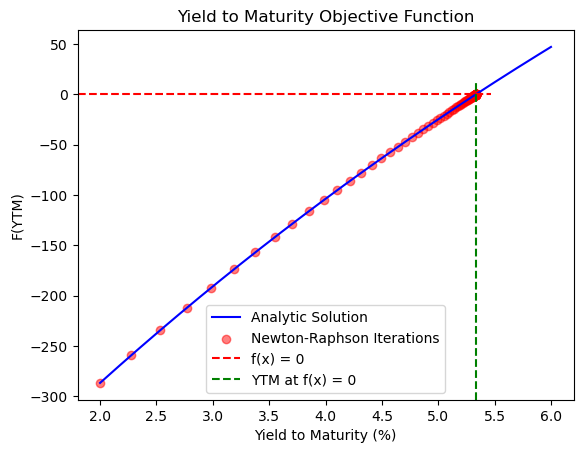

In [ ]:
# plot the objective function for the YTM analytic solution
def plot_ytm(market_price, coupon_rate, n_maturity, face_value):
    
    fig, ax = plt.subplots()
    fx = lambda x: market_price - pv_bond_ytm(coupon_rate, x, n_maturity, face_value)
    x = np.linspace(2, 6, 1000)
    y = [fx(i) for i in x]
    ax.plot(x, y, label = "Analytic Solution", color='blue')
    
    ## for plotting the iterations
    iters = []
    counter = 0
    ytm = 2.0
    ytm_old = 0
    for i in range(10000):
        if abs(ytm - ytm_old) < 1e-6:
            break
        ytm_old = ytm
        pv = pv_bond_ytm(coupon_rate, ytm, n_maturity, face_value)
        if counter % 10 == 0:
            iters.append((ytm, market_price - pv))
        ytm = ytm_old - (market_price - pv) / analytic_derivative(market_price, coupon_rate, ytm, n_maturity, face_value)
        counter += 1
    
    ax.scatter([i[0] for i in iters], [i[1] for i in iters], color='red', label='Newton-Raphson Iterations', alpha=0.5)

    y_zero = 0
    x_zero = x[np.argmin(np.abs(y))]
    ax.axhline(y_zero, color='red', linestyle='--', label='f(x) = 0', xmax=(x_zero - x[0]) / (x[-1] - x[0]))
    ax.axvline(x_zero, color='green', linestyle='--', label='YTM at f(x) = 0', ymax=(y_zero - min(y)) / (max(y) - min(y)))

    ax.set_title("Yield to Maturity Objective Function")
    ax.set_xlabel("Yield to Maturity (%)")
    ax.set_ylabel("f(YTM)")
    ax.legend()
    plt.show()

plot_ytm(920, coupon_rate, n_maturity, face_value)


In [ ]:
def rmse(a, b):
    """
    Compute the root mean square error between two arrays.
    """
    return np.sqrt(np.mean((a - b) ** 2))

[f"{rmse(analytic_ytm[:,0], i[:,0]):0.2e}" for i in [forward_diff_ytm, backward_diff_ytm, central_diff_ytm]]

['3.02e-07', '2.16e-07', '1.50e-12']

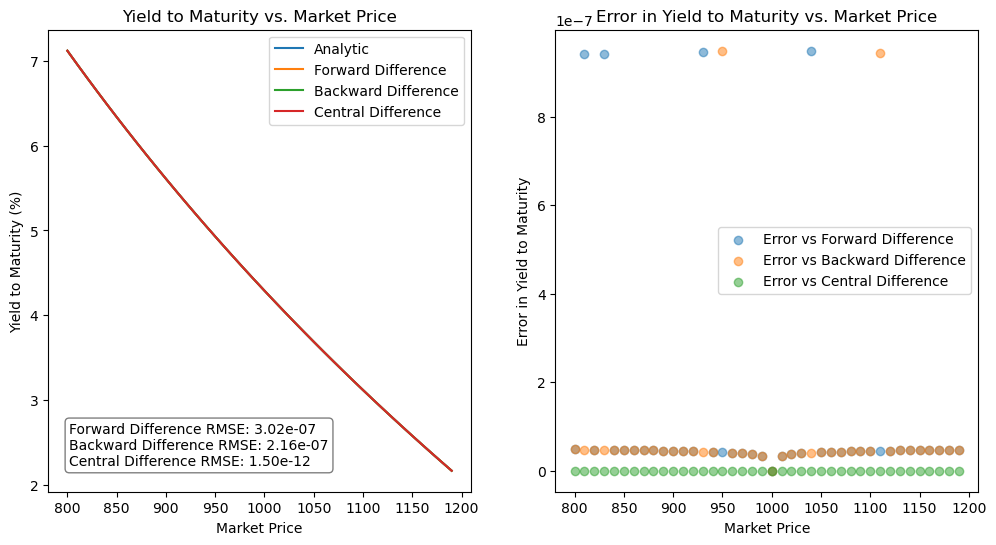

In [162]:
## plot YTM vs. market price
def plot_ytm_vs_price(market_prices, ytms, ytm_labels):
    """
    Plot the yield to maturity against market prices.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    for i, ytm in enumerate(ytms):
        ax1.plot(market_prices, ytm[:, 0], label=ytm_labels[i])
    
    ax1.set_title("Yield to Maturity vs. Market Price")
    ax1.set_xlabel("Market Price")
    ax1.set_ylabel("Yield to Maturity (%)")
    ax1.legend()
    
    # Exclude the analytic method for error calculation
    for i, ytm in enumerate(ytms[1:]):  # Exclude the analytic method for error calculation
        error = np.abs(ytm[:, 0] - ytms[0][:, 0])  # Absolute error compared to analytic method
        ax2.scatter(market_prices, error, label=f"Error vs {ytm_labels[i+1]}", alpha=0.5)
    
    rmse_text = [f"{rmse(analytic_ytm[:,0], i[:,0]):0.2e}" for i in [forward_diff_ytm, backward_diff_ytm, central_diff_ytm]]
    text_str = "\n".join([f"{ytm_labels[i+1]} RMSE: {rmse_text[i]}" for i in range(len(rmse_text))])
    ax1.text(0.05, 0.05, text_str, transform=ax1.transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    ax2.set_title("Error in Yield to Maturity vs. Market Price")
    ax2.set_xlabel("Market Price")
    ax2.set_ylabel("Error in Yield to Maturity")
    ax2.legend()
    
    plt.show()

ytm_labels = ["Analytic", "Forward Difference", "Backward Difference", "Central Difference"]
ytms = [analytic_ytm, forward_diff_ytm, backward_diff_ytm, central_diff_ytm]
plot_ytm_vs_price(market_prices, ytms, ytm_labels)